In [25]:
import pandas as pd

labeled_topics = pd.read_csv("database/labeled_clustering.csv", sep=";")

remove_bad = True
if remove_bad:
    labeled_topics = labeled_topics[labeled_topics["level 1"] != "Human Activities"]
    labeled_topics = labeled_topics[labeled_topics["level 1"] != "People"]
    #labeled_topics = labeled_topics[labeled_topics["level 1"] != "Philosophy"]

labeled_topics


,level 1,level 0
0,Culture,Culture
1,Culture,Art galleries
2,Culture,Museums
3,Culture,Poetry
4,Culture,Fiction
...,...,...
127,Technology,Robotics
128,Technology,Transport
129,Technology,Telecommunications
130,Technology,Environmental technology


/Users/bene/PycharmProjects/Topic Clustering/Clustering.py:146: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



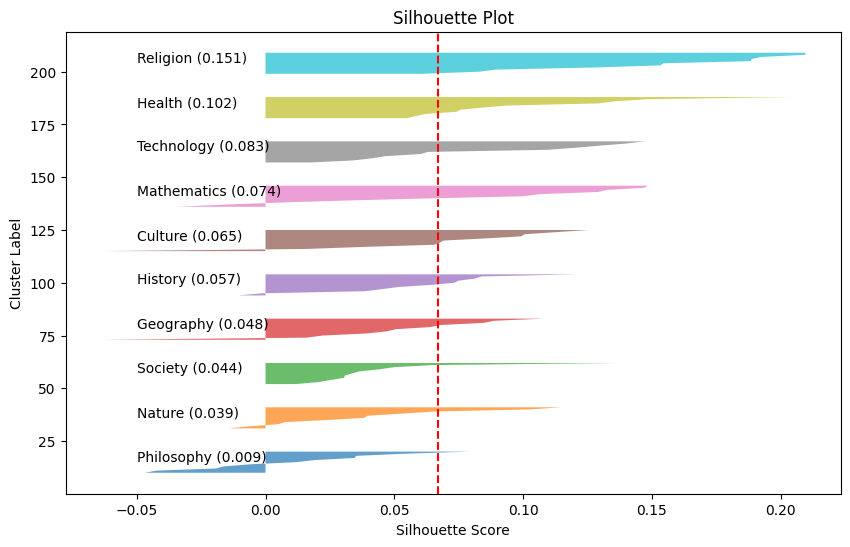

In [71]:
## check the silhoutte score of the labeled data

import Clustering
import DataPrep

keywords = labeled_topics["level 0"].tolist()
cluster_labels = labeled_topics["level 1"]
keyword_embeddings = DataPrep.embed_keywords(keywords)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(keyword_embeddings)

reduce_embeddings = False
if reduce_embeddings:
    keyword_embeddings = tsne_result

from sklearn.metrics import silhouette_samples

cluster_labels_score = silhouette_samples(keyword_embeddings, cluster_labels)
labeled_topics["score"] = cluster_labels_score
Clustering.plot_silhouette(labeled_topics, cluster_label_col='level 1', silhouette_score_col='score', outlier_percentile=1, plot_height=6)

sil_score = labeled_topics["score"].mean()

In [72]:
## Results.csv

testcase,sil_score,rand,adj_rand,jaccard,v-measure
single_euclidean,-0.05224884939056145,0.2618849040867389,0.002064871731740472,0.0930426716141002,0.17846276331902167
single_cosine,-0.05224884939056145,0.2618849040867389,0.002064871731740472,0.0930426716141002,0.17846276331902167
single_tsne,0.24582137807958165,0.8365304420350292,0.34038927036506444,0.27872261072261073,0.6375528734860118
complete_euclidean,0.06570126287647607,0.9119266055045872,0.5187155042649273,0.5852970494417862,0.717151892734163
complete_cosine,0.06570126287647607,0.9119266055045872,0.5187155042649273,0.5852970494417862,0.717151892734163
complete_tsne,0.3984053650725612,0.926605504587156,0.5872562350470748,0.613284632034632,0.7571125447994884
average_euclidean,0.07455104391864203,0.8602168473728107,0.40730118355481726,0.4660839160839161,0.6961999129253569
average_cosine,0.07515074952542568,0.8558798999165972,0.3965784583840584,0.4508814714697067,0.6936003167912655
average_tsne,0.43977752687172456,0.9169307756463719,0.5440249987399829,0.5755310049427697,0.7365643663901273
ward_euclidean,0.07293366495811972,0.9094245204336947,0.48150257115574985,0.5731418285017356,0.6606958331807714
ward_cosine,0.07625861245810732,0.9192660550458716,0.5316323088123014,0.6151695526695528,0.6935228150559418
ward_tsne,0.4110907148447904,0.9316096747289407,0.5981621018936465,0.6612452906570554,0.7590012110430264

NameError: name 'testcase' is not defined

keyword count: 110
cluster count: 10


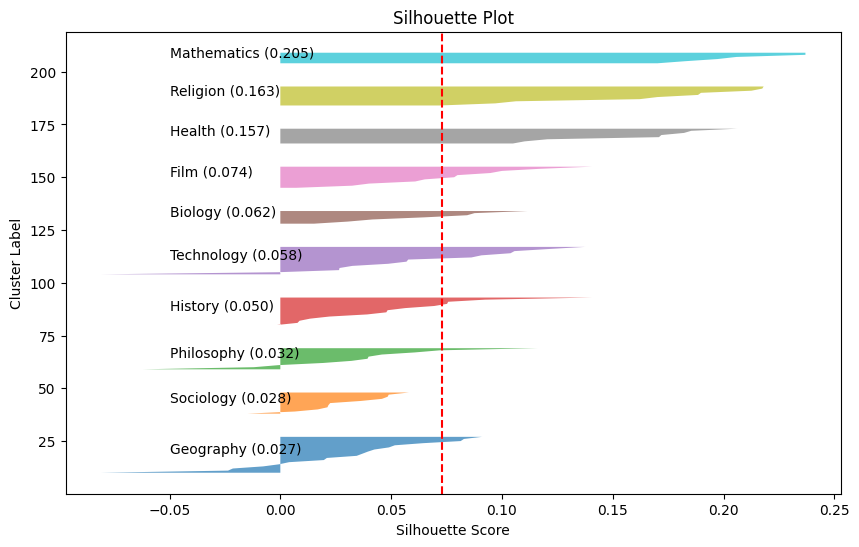

difference between clusters
rand score: 0.9094245204336947, adjusted rand score: 0.48150257115574985
jaccard score 0.5731418285017356
v-measure score 0.6606958331807714
0.07293366495811972,0.9094245204336947,0.48150257115574985,0.5731418285017356,0.6606958331807714


In [75]:
## compare with proposed method

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist

import scipy.cluster.hierarchy as sch

distance_matrix = pdist(keyword_embeddings, metric='euclidean')
Z = linkage(distance_matrix, method='ward')


def show_predicted(cutoff_distance, show_dendrogram=False):
    
    if show_dendrogram:
        from matplotlib import pyplot as plt
        fig = plt.figure(figsize=(15, 20))
        dn = dendrogram(Z, labels=keywords, orientation='right', color_threshold=cutoff_distance)
        
    import numpy as np
    
    mock_appearances = np.full(shape=len(keywords), fill_value=10)
    df = Clustering.keyword_hierachy(keywords, keyword_embeddings, mock_appearances, cutting_distances=[cutoff_distance], Z=Z)
    
    Clustering.plot_silhouette(df, cluster_label_col='level 1', silhouette_score_col='level 1 score', outlier_percentile=1, plot_height=6)
    
    ## how much do the predicted differ from gound truth?
    predicted_cluster_labels = df["level 1"]
    
    compare_df = pd.DataFrame()
    compare_df["topic"] = df["level 0"]
    compare_df["predicted label"] = df["level 1"]
    compare_df["label"] = cluster_labels
    
    return predicted_cluster_labels, df["level 1 score"]

best_cutoff, sil = Clustering.find_best_silhouette_cutoff(Z, keyword_embeddings)
cutoff_distance = Z[-len(cluster_labels.unique()), 2]

predicted_cluster_labels, predicted_cluster_labels_score = show_predicted(cutoff_distance)


mapping, mapped_predictions = Clustering.map_cluster_labels(cluster_labels, predicted_cluster_labels)
combined_predictions = [a + " -> " +  b for a, b in zip(mapped_predictions, predicted_cluster_labels)]

from sklearn.metrics import adjusted_rand_score, jaccard_score, rand_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, jaccard_score, rand_score
    
rand_score = rand_score(cluster_labels, predicted_cluster_labels)
adjusted_rand_score = adjusted_rand_score(cluster_labels, predicted_cluster_labels)

print("difference between clusters")
print(f"rand score: {rand_score}, adjusted rand score: {adjusted_rand_score}")

jaccard_score = jaccard_score(cluster_labels, mapped_predictions, average='macro')
v_measure_score = v_measure_score(cluster_labels, mapped_predictions)
print(f"jaccard score {jaccard_score}")
print(f"v-measure score {v_measure_score}")

sil_score = predicted_cluster_labels_score.mean()

print(f"{sil_score},{rand_score},{adjusted_rand_score},{jaccard_score},{v_measure_score}")


In [76]:
Clustering.plot_tsne_clusters(cluster_labels, tsne_result, keywords, cluster_labels_score)
Clustering.plot_tsne_clusters(pd.Series(combined_predictions), tsne_result, keywords, predicted_cluster_labels_score)

In [ ]:
def plot_tsne_clusters(cluster_labels, tsne_result, labels, score):
    """
    Plots t-SNE clusters, showing a fixed number of labels per cluster to reduce clutter.
    All labels are still visible in the hover tooltip.

    Parameters:
    - cluster_labels: Array or list of cluster labels
    - tsne_result: 2D t-SNE result array (shape: [n_samples, 2])
    - labels: Array or list of labels to display on the plot
    - labels_per_cluster: Number of labels to display per cluster (default is 5)

    Returns:
    - fig: Plotly figure object
    """
    # Combine tsne_result, cluster_labels, and labels into a DataFrame
    plot_data = pd.DataFrame({
        'tsne_x': tsne_result[:, 0],
        'tsne_y': tsne_result[:, 1],
        'cluster': cluster_labels,
        'score': score,
        'label': labels
    })

    # Sort the data by cluster labels
    plot_data = plot_data.sort_values(by='cluster').reset_index(drop=True)

    # Create a scatter plot with Plotly
    fig = px.scatter(
        plot_data,
        x='tsne_x', y='tsne_y',
        color='cluster',
        text="label",
        hover_name='label',  # This ensures all labels are visible on hover
        labels={'color': 'Cluster Label', 'score': 'score'},
        template='plotly_white'
    )

    # Adjust the layout to ensure labels are visible
    fig.update_traces(textposition='top center')

    # Show the plot
    fig.show()

In [36]:
df = pd.DataFrame({
    'topic': keywords,
    'predicted': mapped_predictions,
    'truth': cluster_labels
})

# Filter where predicted differs from actual
df_filtered = df[df['predicted'] != df['truth']]
df_filtered

,topic,predicted,truth
0,Culture,Society,Culture
3,Poetry,Nature,Culture
12,Earth,Nature,Geography
13,Climate,Nature,Geography
14,Demographics,People,Geography
24,Nutrition,Human Activities,Health
25,Physical fitness,Human Activities,Health
32,Body composition,Human Activities,Health
40,World War I,Human Activities,History
41,World War II,Human Activities,History


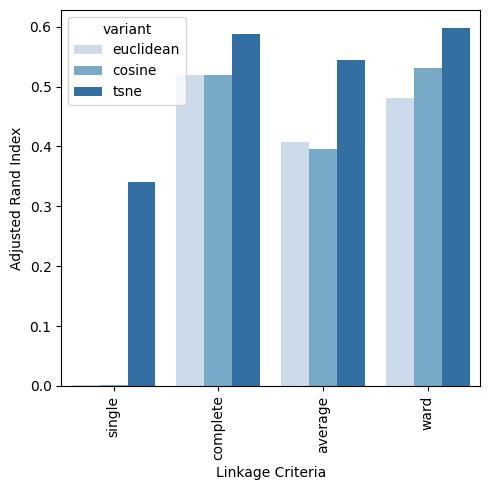

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

linkage_comparison = pd.read_csv("database/linkage_comparison.csv")

linkage_comparison['linkage_method'] = linkage_comparison['testcase'].apply(lambda x: '_'.join(x.split('_')[:-1]))
linkage_comparison['variant'] = linkage_comparison['testcase'].apply(lambda x: x.split('_')[-1])

# Plot using seaborn, grouping by linkage method and coloring by variant
plt.figure(figsize=(5, 5))
sns.barplot(data=linkage_comparison, x='linkage_method', y='adj_rand', hue='variant', palette="Blues")

# Add title and labels
plt.title('')
plt.ylabel('Adjusted Rand Index')
plt.xlabel('Linkage Criteria')
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()